# AniList scraper by Bence

Strictly to be used for education purposes (Otherwise it breaks the AniList API ToS)

I used chatgpt handily while making this but I tried to spend some effort actually checking everything, removing and fixing stupid stuff it was doing and testing that it's behaving correctly.
The main bottleneck is AniLists rate limiting, currently it's set to 30 requests a minute, and if you keep trying to request when you run out it'll just timeout you for 60s so I made sure to
keep that in check.\
Please read the full guide here, it contains important information on how to tweak download time and how the scraper works.

example usage:
```python
anime_data = fetch_anilist_top_entries(media_limit=5, page=1, max_characters=50, max_staff=50)
```

It has the following arguements you can use:\
(all of them are predefined)
```python
def fetch_anilist_top_entries(
        media_type="ANIME",
        media_limit=50,
        page=1,
        max_characters=25,
        max_staff=25,
        sort=["POPULARITY_DESC"]
    ):
```
**Tip:** you can set `media_limit`, `max_characters`, `max_staff` to -1 to just download everything.

- **media_type**: Type of media to fetch. `"ANIME"` for anime, `"MANGA"` for manga.
- **media_limit**: Total number of media entries to fetch (e.g., 50 for top 50 anime).\
This one spends 1 API request per 50 animes.
- **page**: Starting page number for pagination (default is 1).
- **max_characters**: Maximum number of characters to fetch per media entry.\
This one spends 1 API request per 25 characters.
- **max_staff**: Maximum number of staff members to fetch per media entry.\
This one spends 1 API request per 25 staff.
- **sort**: List of sorting criteria, e.g., `["POPULARITY_DESC"]` for most popular first. See AniList API docs for other options.

## Pagination and API Requests

AniList's API uses pagination for all its queries, meaning you can only fetch a limited number of items per request:

- **Media**: Each request for media (anime/manga) returns up to 50 entries per page. When you fetch more than 50, the `page` parameter is incremented and it makes additional requests.
- **Characters & Staff**: For each media entry, characters and staff are also paginated, with up to 25 entries per request. If a show has more than 25 characters or staff, the code will make multiple requests (incrementing the `page` parameter) until it collects the desired number or there are no more entries.

**API Request Calculation Example:**  
Suppose you want to fetch 200 anime, with up to 50 characters and 25 staff per anime:

- **Media requests:**  
    200 anime / 50 per request = 4 requests

- **Character requests:**  
    Each anime: 50 characters / 25 per request = 2 requests  
    For 200 anime: 2 × 200 = 400 requests

- **Staff requests:**  
    Each anime: 25 staff / 25 per request = 1 request  
    For 200 anime: 1 × 200 = 200 requests

- **Total requests:**  
    4 (media) + 400 (characters) + 200 (staff) = **604 requests**

At 30 requests per minute, this would take about 20 minutes (604 / 30 ≈ 20).  
**Tip:** Lowering `max_characters` and `max_staff` reduces the number of requests drastically.\
There are usually below 100 characters per anime (there are big outliers sometimes like ONE PIECE)\
There are usually between 1000 and 100 staff per anime.

In [ ]:
import requests
import time
import re
import datetime
import keyboard
import json
import sys


# -----------------------------------------------------
#  Helpers
# -----------------------------------------------------

API_URL = "https://graphql.anilist.co"
HEADERS = {"Content-Type": "application/json", "Accept": "application/json"}

current_filesize = 0
N_collected_media = 0
start_time = datetime.datetime.now()
handle_time = datetime.datetime.now()
from IPython.display import clear_output

def update_block(lines):
    clear_output(wait=True)
    print(f"Download started at {start_time.strftime('%Y-%m-%d %H:%M:%S')}") # keep this line
    for line in lines:
        print(line)

def graphql_request(query, variables, max_retries=5):
    """Generic POST request with retry on rate-limit."""
    global handle_time
    elapsed = (datetime.datetime.now() - handle_time).total_seconds()
    handle_time = datetime.datetime.now()
    while True and not keyboard.is_pressed('esc'):
        for attempt in range(max_retries):
            if keyboard.is_pressed('esc'):
                return None
            resp = requests.post(API_URL, json={"query": query, "variables": variables}, headers=HEADERS)

            global current_filesize
            update_block([
                f"Number of anime downloaded: {N_collected_media}",
                f"Current data size: {current_filesize} bytes / {current_filesize / (1024*1024):.2f} MB",
                f"Requests remaining: {resp.headers.get('X-RateLimit-Remaining', 0)}",
                f"Time since last request: {elapsed:.3f}s"
            ])
            time.sleep(1.6) # it almost always takes more than 0.4s to process the request, so wait 1.6s to make it 2s between requests

            if resp.status_code == 200:
                return resp.json()

            if resp.status_code == 429:
                retry_after = int(resp.headers.get("Retry-After", 10))
                #print(f"Rate limited. Retrying in {retry_after}s…")
                update_block([
                    f"Number of anime downloaded: {N_collected_media}",
                    f"Current data size: {current_filesize} bytes / {current_filesize / (1024*1024):.2f} MB",
                    f"Rate limited. Retrying in {retry_after}s…"
                ])
                time.sleep(retry_after + 1)
                continue
            
            # resp.raise_for_status()
            print(f"Error {resp.status_code}: {resp.text}")
            time.sleep(60)
        print("Max retries exceeded. Waiting for 230 seconds before retrying…")
        time.sleep(230)

    #raise RuntimeError("Exceeded max retries for AniList API.")


# -----------------------------------------------------
#  Staff Role Parsing
# -----------------------------------------------------

def expand_range(text):
    start, end = map(int, text.split('-'))
    return list(range(start, end + 1))


def parse_staff_role(role_text):
    base_role = role_text
    episodes = []
    tags = []

    m = re.search(r"\((.*?)\)", role_text) # example: Episode director (eps 1-12, 14, 16-18, ED1)
    if m:
        inside = m.group(1).strip()               # gets: eps 1-12, ep 5, 14, 16-18, ED1
        base_role = role_text[:m.start()].strip() # gets: Episode director

        parts = [p.strip() for p in inside.split(",")]

        for p in parts:

            if re.match(r"ep?s?\s*\d+\s*-\s*\d+", p): # matches: eps 1-12
                for r in re.findall(r"\d+-\d+", p):
                    episodes.extend(expand_range(r))  # list <- [1,2,3,...,12]
                continue

            if re.match(r"^\d+\s*-\s*\d+$", p):       # matches: 16-18
                episodes.extend(expand_range(p))      # list <- [16,17,18]
                continue

            if re.match(r"ep?s?\s*\d+$", p):          # matches: ep 5
                episodes.append(int(re.findall(r"\d+", p)[0]))
                continue

            if re.match(r"^\d+$", p):                 # matches: 14
                episodes.append(int(p))
                continue

            tags.append(p)                     # anything else is a tag

    return {
        "base_role": base_role,
        "episodes": sorted(set(episodes)),
        "tags": tags
    }


# -----------------------------------------------------
#  Character Description Parsing
# -----------------------------------------------------

def split_character_description(character):
    """
    Splits the character's description into 'attributes' (dict) and 'description' (str).
    Attributes are detected by the pattern '__Attribute:__ value\n'.
    Removes markdown links like [text](url) from the description, keeping only 'text'.
    Removes all '\n' from the description.
    Keeps all other fields (like 'name') intact.
    """
    desc = character.get('description', '')
    if not isinstance(desc, str):
        desc = ''

    # Remove markdown links: [text](url) -> text
    desc = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', desc)

    # Extract attributes
    attributes = {}
    pattern = re.compile(r'__([A-Za-z ]+):__\s*(.*?)\n', re.DOTALL)
    matches = list(pattern.finditer(desc))
    for match in matches:
        key = match.group(1).strip()
        value = match.group(2).strip()
        attributes[key] = value

    cleaned_desc = pattern.sub('', desc).strip() # Remove attributes from description
    cleaned_desc = cleaned_desc.replace('\n', ' ')

    # change attributes and description while keeping other fields intact
    result = character.copy() 
    result['attributes'] = attributes
    result['description'] = cleaned_desc
    return result

# -----------------------------------------------------
#  Queries
# -----------------------------------------------------

MEDIA_QUERY = """
query ($type: MediaType, $page: Int, $sort: [MediaSort]) {
    Page(page: $page, perPage: 50) {
        pageInfo { hasNextPage }
        media(type: $type, sort: $sort) {
            id
            title { romaji english native }
            popularity
            averageScore
            episodes
            nextAiringEpisode { episode }
            genres
            tags { name }
            studios { nodes { name } }
            stats { scoreDistribution { score amount } statusDistribution { status amount } }
            startDate { year month day }
            endDate { year month day }
            duration
            description
        }
    }
}
"""

STAFF_QUERY = """
query ($mediaId: Int, $page: Int) {
  Media(id: $mediaId) {
    staff(page: $page, perPage:25) {
      pageInfo { hasNextPage }
      edges {
        role
        node { name { full } }
        id
      }
    }
  }
}
"""

CHAR_QUERY = """
query ($mediaId: Int, $page: Int) {
  Media(id: $mediaId) {
    characters(page: $page, perPage:25) {
      pageInfo { hasNextPage }
      edges {
        node {
          name { full }
          description
          id
        }
        voiceActors(language: JAPANESE, sort: [RELEVANCE, ID]) {
          name { full }
          id
        }
      }
    }
  }
}
"""


# -----------------------------------------------------
#  Pagination helpers
# -----------------------------------------------------
data = None

def fetch_paginated(query, variables, path, max_results=25):
    """Fetch paginated AniList data under the given JSON path."""
    page = 1
    results = []

    while max_results == -1 or len(results) < max_results:
        variables["page"] = page
        data = graphql_request(query, variables)
        if data is None:
            return None
        # dig into nested JSON
        # example: extract data["data"]["Media"]["staff"] from data
        node = data["data"] 
        for p in path:      
            node = node[p]

        edges = node["edges"]
        results.extend(edges)

        if not node["pageInfo"]["hasNextPage"]:
            break

        page += 1

    return results


# -----------------------------------------------------
#  Character & Staff Processing
# -----------------------------------------------------

def simplify_character(node_edge):
    node = node_edge["node"]
    jp_va = node_edge.get("voiceActors", [])
    first_va = jp_va[0]["name"]["full"] if jp_va else None

    return split_character_description({
        "name": node["name"]["full"],
        "description": node.get("description"),
        "japanese_va": first_va,
        "character_id": node["id"],
        "va_id": jp_va[0]["id"] if jp_va else None
    })


def simplify_staff(edge):
    name = edge["node"]["name"]["full"]
    role = edge["role"]
    parsed = parse_staff_role(role)
    return {
        "name": name,
        "role": parsed["base_role"],
        "episodes": parsed["episodes"],
        "tags": parsed["tags"],
        "id": edge["id"]
    }


# -----------------------------------------------------
#  Main scraper
# -----------------------------------------------------

def fetch_anilist_top_entries(
        media_type="ANIME",
        media_limit=50,
        page=1,
        max_characters=25,
        max_staff=25,
        sort=["POPULARITY_DESC"]
    ):

    global start_time
    start_time = datetime.datetime.now()
    print(f"Download started at {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

    global current_filesize
    global N_collected_media
    N_collected_media = 0
    start_page = page
    per_page = 50 # fixed by the MEDIA_QUERY
    collected_media = []

    while media_limit == -1 or (page-start_page) * per_page < media_limit:
        variables = {"type": media_type, "page": page, "perPage": per_page, "sort": sort}
        response = graphql_request(MEDIA_QUERY, variables)
        if response is None:
            break
        data = response["data"]["Page"]
        media_batch = data["media"]
        collected_media.extend(media_batch)
        if not data["pageInfo"]["hasNextPage"]:
            break

        page += 1

    # Trim to exact media limit
    collected_media = collected_media[:media_limit]

    rank = 1 + (start_page - 1) * per_page
    # Fetch characters + staff for each
    for media in collected_media:
        if not keyboard.is_pressed('esc'):
            pass
        else:
            print("\nDownload interrupted by user.")
            break
        media_id = media["id"]
        media["rank"] = rank
        rank += 1

        # Staff
        raw_staff = fetch_paginated(STAFF_QUERY, {"mediaId": media_id}, ["Media", "staff"], max_staff)
        if raw_staff is None:
            simplified_staff = []
        else:
            simplified_staff = [simplify_staff(edge) for edge in raw_staff]

        # Characters
        raw_chars = fetch_paginated(CHAR_QUERY, {"mediaId": media_id}, ["Media", "characters"], max_characters)
        if raw_chars is None:
            simplified_chars = []
        else:
            simplified_chars = [simplify_character(edge) for edge in raw_chars]

        # Description (remove <br><br>\r\n)
        if "description" in media and isinstance(media["description"], str):
            media["description"] = re.sub(r'<br\s*/?><br\s*/?>\s*', ' ', media["description"]).strip()
        else:
            media["description"] = ""

        # Tags
        media["tags"] = [tag["name"] for tag in media.get("tags", [])]
        # Studios
        media["studios"] = [studio["name"] for studio in media.get("studios", {}).get("nodes", [])]
        # next airing episode
        if "nextAiringEpisode" in media and isinstance(media["nextAiringEpisode"], dict):
            media["nextAiringEpisode"] = media["nextAiringEpisode"].get("episode")
        else:
            media["nextAiringEpisode"] = None

        media["staff"] = simplified_staff
        media["characters"] = simplified_chars

        current_filesize = sys.getsizeof(json.dumps(collected_media))
        N_collected_media += 1

        # Debug print
        #print(f"{media['title']['romaji']}: {len(simplified_chars)} chars, {len(simplified_staff)} staff")
    
    collected_media = collected_media[:N_collected_media]
    end_time = datetime.datetime.now()
    print(f"\nDownload completed at {end_time.strftime('%Y-%m-%d %H:%M:%S')}, duration: {end_time - start_time}")

    return collected_media


# Social Graphs and Interactions final project assignment B
Bence Gattyan - s204773
Gokul Desu - 242580

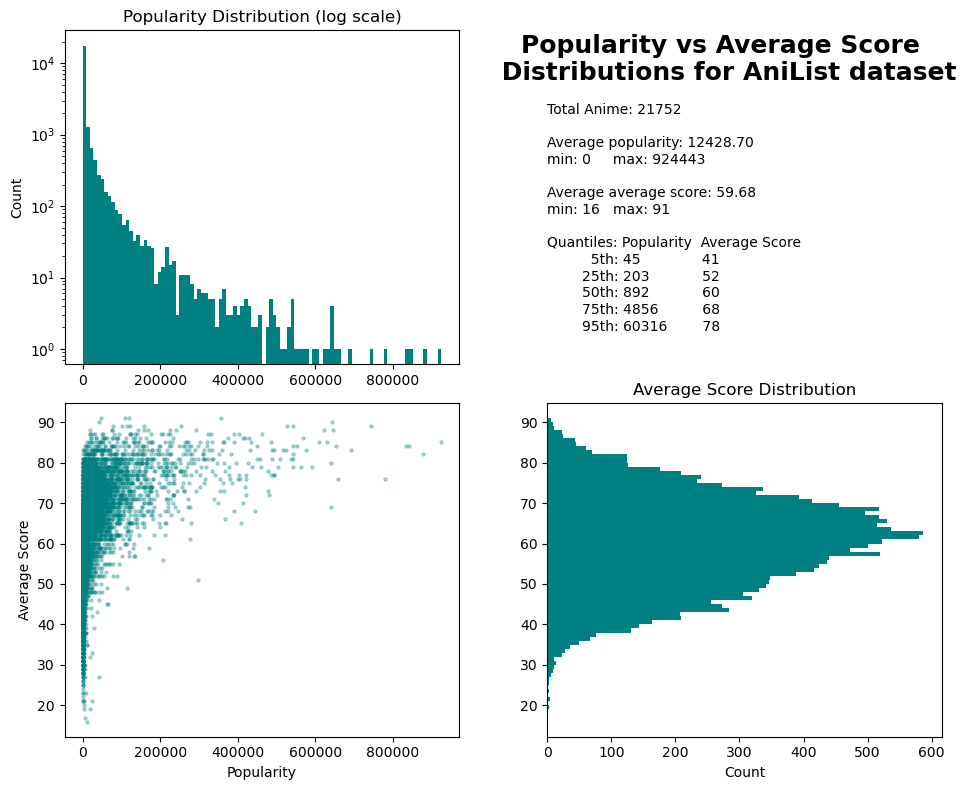

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

with open('data/anime_data_0-21000+.json', 'r') as file:
    df = pd.DataFrame(json.load(file))

df['num_characters'] = df['characters'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['num_staff'] = df['staff'].apply(lambda x: len(x) if isinstance(x, list) else 0)

x = df['popularity']
y = df['averageScore']

plt.style.use('default')
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title("Popularity Distribution (log scale)")
plt.hist(x, bins=100, color='teal')
plt.yscale("log")
plt.ylabel("Count")

plt.subplot(2, 2, 4)
plt.title("Average Score Distribution")
plt.hist(y.dropna(), bins=75, color='teal', orientation='horizontal')
plt.xlabel("Count")

plt.subplot(2, 2, 3)
plt.scatter(x, y, alpha=0.3, s=5, color='teal')
plt.xlabel("Popularity")
plt.ylabel("Average Score")

plt.subplot(2, 2, 2)
plt.axis('off')
plt.text(0.45, 0.85, f"Popularity vs Average Score \n Distributions for AniList dataset", fontsize=18, horizontalalignment='center', fontweight='bold')
plt.text(0.0, 0.75, f"Total Anime: {len(x)}", fontsize=10)
plt.text(0.0, 0.65, f"Average popularity: {sum(x)/len(x):.2f}", fontsize=10)
plt.text(0.0, 0.60, f"min: {min(x):.0f}     max: {max(x):.0f}", fontsize=10)
plt.text(0.0, 0.50, f"Average average score: {sum(y.dropna())/len(y.dropna()):.2f}", fontsize=10)
plt.text(0.0, 0.45, f"min: {min(y.dropna()):.0f}   max: {max(y.dropna()):.0f}", fontsize=10)
plt.text(0.0, 0.35, f"Quantiles: Popularity  Average Score", fontsize=10)
plt.text(0.0, 0.30, f"          5th: {np.percentile(x, 5):.0f}              {np.percentile(y.dropna(), 5):.0f}", fontsize=10)
plt.text(0.0, 0.25, f"        25th: {np.percentile(x, 25):.0f}            {np.percentile(y.dropna(), 25):.0f}", fontsize=10)
plt.text(0.0, 0.20, f"        50th: {np.percentile(x, 50):.0f}            {np.percentile(y.dropna(), 50):.0f}", fontsize=10)
plt.text(0.0, 0.15, f"        75th: {np.percentile(x, 75):.0f}          {np.percentile(y.dropna(), 75):.0f}", fontsize=10)
plt.text(0.0, 0.10, f"        95th: {np.percentile(x, 95):.0f}        {np.percentile(y.dropna(), 95):.0f}", fontsize=10)
plt.tight_layout()
plt.show()


In [2]:
    # Code that was used to find similar staff role names, there were some typos in the dataset that had to be corrected.
    # Number of unique staff roles changed from ~6100 to ~5500 after cleaning.


    ##################################   Parse ep counts out from staff role titles ##################################


from collections import defaultdict
import re
import json
fixStaffRoles = False


if fixStaffRoles:

        EP_RANGE    = re.compile(r"\b(\d+)\s*-\s*(\d+)\b")
        EP_SINGLE   = re.compile(r"\b\d+\b")

        def expand_range(a, b):
            return list(range(int(a), int(b) + 1))

        def parse_staff_role(staff):
            name = staff["name"]
            role = staff["role"]
            episodes = staff["episodes"]
            tags = staff["tags"]

            # --- 1. Extract the part inside the first "(" until the end ---
            m = re.search(r"\((.*)$", role)
            if not m:
                return {
                    "name": name,
                    "base_role": role.strip(),
                    "episodes": sorted(set(episodes)),
                    "tags": tags
                }

            inside = m.group(1).strip()
            base_role = role[:m.start()].strip()

            # Remove trailing unmatched ')'
            inside = inside.rstrip(")")

            # Normalize separators
            inside = inside.replace("&", ",")
            inside = inside.replace(";", ",")
            inside = inside.replace("eps.", "eps ")
            inside = inside.replace("ep.", "ep ")

            # Split into pieces
            parts = [p.strip().rstrip(",") for p in inside.split(",") if p.strip()]

            for p in parts:

                # Ignore OP/ED tags (except ranges)
                if re.match(r"^(OP|ED)[0-9A-Za-z-]*$", p):
                    tags.append(p)
                    continue

                # OP/ED ranges like OP1-OP13
                m_range_tag = re.match(r"^(OP|ED)(\d+)\s*-\s*\1(\d+)$", p)
                if m_range_tag:
                    tags.append(p)
                    continue

                # Episode ranges
                for a, b in EP_RANGE.findall(p):
                    episodes.extend(expand_range(a, b))
                    # After extracting range, continue next p
                    break
                else:
                    # Single episode numbers
                    nums = EP_SINGLE.findall(p)
                    if nums:
                        episodes.extend(int(x) for x in nums)
                    else:
                        # Anything else is a tag
                        tags.append(p)

            return {
                "name": name,
                "base_role": base_role,
                "episodes": list(sorted(set(episodes))),
                "tags": list(set(tags))
            }


        #######################################  Conversion from anime centric dataset to staff centric dataset #######################################

        # Dictionary to collect staff info: staff_name -> {'anime': [(anime_id, role, episodes, tags), ...]}
        def extract_staff_info(df):
            staff_dict = {}
            for idx, row in df.iterrows():
                anime_id = row['id']
                staff_list = row['staff']
                anime_start = row["startDate"]
                anime_end = row["endDate"]
                anime_episodes = row["episodes"] if row["episodes"] is not None else row["nextAiringEpisode"]
                anime_popularity = row["popularity"]

                for staff in staff_list:
                    if "(" not in staff.get('role'):
                        staff_name = staff.get('name')
                        role = staff.get('role')
                        episodes = staff.get('episodes')
                        tags = staff.get('tags')
                    else:
                        parsed = parse_staff_role(staff)
                        staff_name = parsed['name']
                        role = parsed['base_role']
                        episodes = parsed['episodes']
                        tags = parsed['tags']
                    if staff_name is not None:
                        if staff_name not in staff_dict:
                            staff_dict[staff_name] = {'anime': []}
                        staff_dict[staff_name]['anime'].append({
                            'anime_id': anime_id,
                            'role': role,
                            'episodes': episodes,
                            'tags': tags,
                            'anime_start': anime_start,
                            'anime_end': anime_end,
                            'anime_episodes': anime_episodes,
                            'anime_popularity': anime_popularity
                        })
            return staff_dict

        staff_dict = extract_staff_info(df)

        # Convert to DataFrame
        staff_dataset = pd.DataFrame([
            {'staff_name': name, 'anime': info['anime']}
            for name, info in staff_dict.items()
        ])

        from collections import Counter, defaultdict

        # Count total occurrences of each role and number of unique staff per role
        role_occurrences = Counter()
        role_staff = defaultdict(set)

        for staff_name, info in staff_dict.items():
            for entry in info['anime']:
                role = entry['role']
                if role is not None:
                    role_occurrences[role] += 1
                    role_staff[role].add(staff_name)

        # Prepare results: role -> (total_occurrences, unique_staff_count)
        role_stats = {
            role: (count, len(role_staff[role]))
            for role, count in role_occurrences.items()
        }

        # Plot top 10 roles by total occurrences and unique staff as horizontal barplots in two subplots
        top_roles = sorted(role_stats.items(), key=lambda x: x[1][0], reverse=True)[:100]
        roles = [role for role, _ in top_roles]
        totals = [total for _, (total, _) in top_roles]
        top_unique_roles = sorted(role_stats.items(), key=lambda x: x[1][1], reverse=True)[:100]
        roles_unique = [role for role, _ in top_unique_roles]
        uniques = [unique for _, (_, unique) in top_unique_roles]

        role_stats = {
            role: (count, len(role_staff[role]))
            for role, count in role_occurrences.items()
        }

        roleNamesSorted = list(dict(sorted(role_stats.items(), key=lambda x: x[1][0], reverse=True)).keys())


        #########################################  Finding similar role names  #########################################


        from difflib import SequenceMatcher

        def find_similar_names(names, threshold=0.95):
            similar_pairs = []
            names = list(names)
            checked = set()
            n = len(names)

            for i in range(n):
                if i % 100 == 0:
                    print(f"Checking name {i+1}/{n}: {names[i]}")
                for j in range(i+1, n):
                    name1, name2 = names[i], names[j]
                    if name1 == name2 or (name1, name2) in checked or (name2, name1) in checked:
                        continue
                    ratio = SequenceMatcher(None, name1, name2).ratio()
                    if ratio >= threshold:
                        similar_pairs.append((name1, name2, ratio))
                        checked.add((name1, name2))
            return similar_pairs

        similar_role_names2 = find_similar_names(roleNamesSorted)
        for name1, name2, ratio in similar_role_names2:
            print(f"{name1} <-> {name2} (similarity: {ratio:.2f})")


        from difflib import SequenceMatcher
        from concurrent.futures import ThreadPoolExecutor, as_completed

        def find_similar_names_threaded(names, threshold=0.95, max_workers=8):
            similar_pairs = []
            names = list(names)
            checked = set()
            n = len(names)

            def compare_pair(i, j):
                name1, name2 = names[i], names[j]
                if name1 == name2 or (name1, name2) in checked or (name2, name1) in checked:
                    return None
                ratio = SequenceMatcher(None, name1, name2).ratio()
                if ratio >= threshold:
                    return (name1, name2, ratio)
                return None

            with ThreadPoolExecutor(max_workers=max_workers) as executor:
                futures = []
                for i in range(n):
                    if i % 100 == 0:
                        print(f"Checking name {i+1}/{n}: {names[i]}")
                    for j in range(i+1, n):
                        futures.append(executor.submit(compare_pair, i, j))
                for future in as_completed(futures):
                    result = future.result()
                    if result:
                        similar_pairs.append(result)
                        checked.add((result[0], result[1]))
            return similar_pairs

        #cleaned_names = list(set([y.lower() for y in [x[:-1] if x.endswith(' ') else x for x in roleNamesSorted]]))
        similar_role_names2 = find_similar_names_threaded(roleNamesSorted)
        for name1, name2, ratio in similar_role_names2:
            print(f"{name1} <-> {name2} (similarity: {ratio:.2f})")


        ##################################  Merging data of similar role names ####################################

        total_merged = {}
        discard = []
        role_stats_sorted = sorted(role_stats.items(), key=lambda x: x[1][0], reverse=True)
        reroute = {}

        i = 0
        for role1, (total1, unique1) in role_stats_sorted:
            i += 1
            if i % 100 == 0:
                print(f"Processing role {i+1}/{len(role_stats_sorted)}: {role1}")
            for role2, (total2, unique2) in role_stats_sorted:
                if role1 not in discard:
                    if role1 not in total_merged:
                        total_merged[role1] = [total1, unique1]
                        reroute[role1] = [role1]
                    role1_lower = role1.lower()[:-1] if role1.endswith(' ') else role1.lower()
                    role2_lower = role2.lower()[:-1] if role2.endswith(' ') else role2.lower()
                    if role1 != role2:
                        if role1_lower == role2_lower:
                            # Merge role2 into role1
                            # print(f"{total_merged[role1]} {role1} <- {role2} {(total2, unique2)}")
                            total_merged[role1][0] += total2
                            total_merged[role1][1] += unique2
                            # print(f"{total_merged[role1]}")
                            reroute[role2] = [role1]
                            discard.append(role2)
                        elif any({x, y} == {role1_lower, role2_lower} for x, y, _ in similar_role_names):
                            # Merge role2 into role1
                            total_merged[role1][0] += total2
                            total_merged[role1][1] += unique2
                            reroute[role2] = [role1]
                            discard.append(role2)


        # reroute and total_merged can be inspected

else:
        with open('data/reroute.json', 'r') as file:
            reroute = json.load(file)
        with open('data/total_merged.json', 'r') as file:
            total_merged = json.load(file)
        with open('data/staff_dict.json', 'r') as file:
            staff_dict = json.load(file)


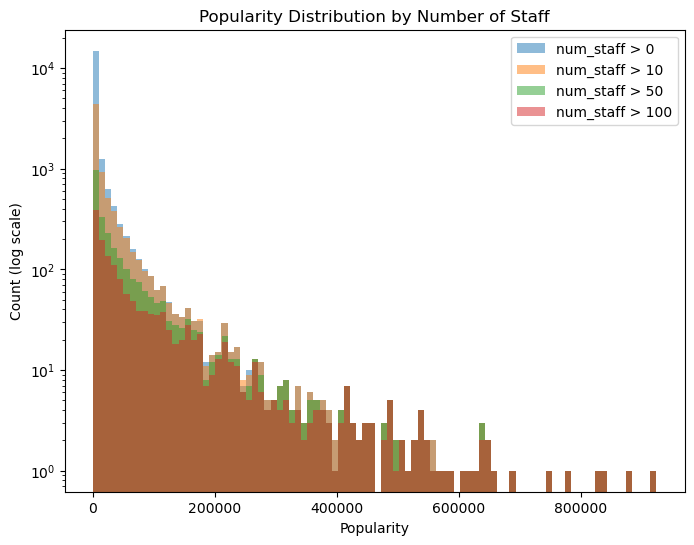

In [3]:
# Justification for only using animes with num_staff > 100 for collecting staff data
# tldr there are a lot of poorly documented animes + we don't have the compute to make a full network out of the 21k anime 80k staff dataset
# if we limit it to staff count > 100 the popularity distribution still stays about the same while solving both problems

filters = [0, 10, 50, 100]
plt.figure(figsize=(8, 6))
for i, threshold in enumerate(filters):
    filtered = df[df['num_staff'] > threshold]['popularity']
    plt.hist(filtered, bins=92, alpha=0.5, label=f'num_staff > {threshold}', log=True)
plt.title('Popularity Distribution by Number of Staff')
plt.xlabel('Popularity')
plt.ylabel('Count (log scale)')
plt.legend()
plt.show()

C:\Users\bence\AppData\Local\Temp\ipykernel_3848\2181345115.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df100['role_counts'] = df100.apply(count_roles, axis=1)


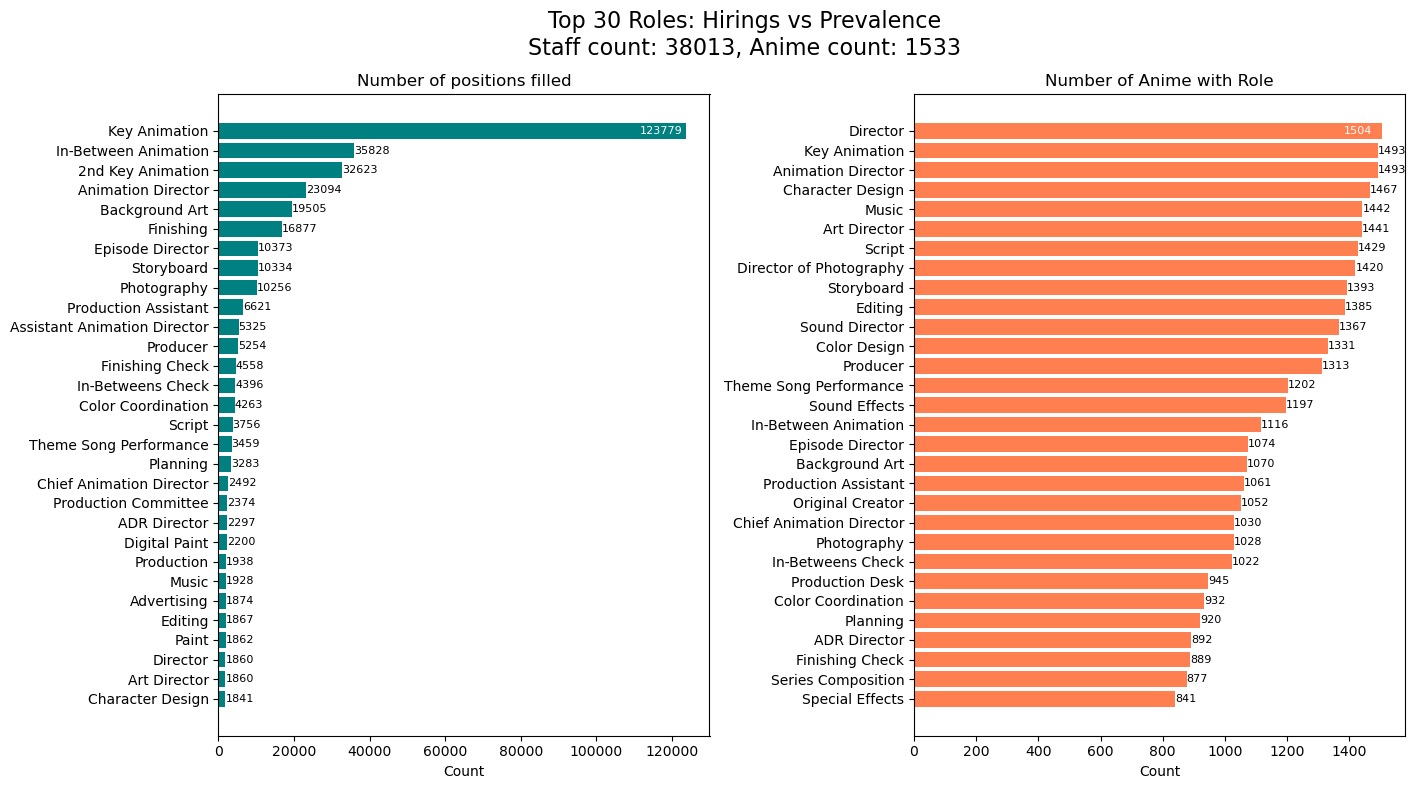

In [4]:
staffMin100 = list(df[df['num_staff'] > 100]['id'])
staff_dict_100 = {name: info for name, info in staff_dict.items() if all(x['anime_id'] in staffMin100 for x in info['anime'])}

for staff in staff_dict_100.values():
    for entry in staff['anime']:
        role = entry['role']
        if role in reroute:
            new_role = reroute[role][0]
            entry['role'] = new_role

df100 = df[df['num_staff'] > 100]

def count_roles(row):
    role_counts = {}
    for staff in row['staff']:
        role = staff['role']
        if role in reroute:
            new_role = reroute[role][0]
            staff['role'] = new_role
            role = new_role
        role_counts[role] = role_counts.get(role, 0) + 1
    return role_counts

df100['role_counts'] = df100.apply(count_roles, axis=1)

total_role_counts = {}
for role_counts in df100['role_counts']:
    for role, count in role_counts.items():
        if role not in total_role_counts:
            total_role_counts[role] = [0, 0]
        total_role_counts[role][0] += count
        total_role_counts[role][1] += 1  # unique staff count increment
top_roles = sorted(total_role_counts.items(), key=lambda x: x[1][0], reverse=True)[:30]
roles = [role for role, _ in top_roles]
totals = [total for _, (total, _) in top_roles]
top_unique_roles = sorted(total_role_counts.items(), key=lambda x: x[1][1], reverse=True)[:30]
roles_unique = [role for role, _ in top_unique_roles]
uniques = [unique for _, (_, unique) in top_unique_roles]


# Plot top 10 roles by total occurrences and unique staff as horizontal barplots in two subplots

plt.figure(figsize=(15, 8))
plt.suptitle(f"Top 30 Roles: Hirings vs Prevalence\nStaff count: {len(staff_dict_100)}, Anime count: {len(df100)}", fontsize=16)

plt.subplot(1, 2, 1)
bars = plt.barh(roles[:30], totals[:30], color='teal')
plt.title("Number of positions filled")
plt.xlabel("Count")
plt.gca().invert_yaxis()
# Move the first bar label to the left of the bar, keep the rest as is
for i, (bar, total) in enumerate(zip(bars, totals)):
    if i == 0:
        plt.text(bar.get_width() - bar.get_width()*0.1, bar.get_y() + bar.get_height()/2, f'{total}', va='center', ha='left', fontsize=8, color='white')
    else:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{total}', va='center', ha='left', fontsize=8)

plt.subplot(1, 2, 2)
bars2 = plt.barh(roles_unique, uniques, color='coral')
plt.title("Number of Anime with Role")
plt.xlabel("Count")
plt.gca().invert_yaxis()
for i, (bar, total) in enumerate(zip(bars2, uniques)):
    if i == 0:
        plt.text(bar.get_width() - bar.get_width()*0.08, bar.get_y() + bar.get_height()/2, f'{total}', va='center', ha='left', fontsize=8, color='white')
    else:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{total}', va='center', ha='left', fontsize=8)

plt.tight_layout(rect=[0, 0, 0.95, 1]) 
plt.show()

Role-role network: 1578 nodes, 7869 edges


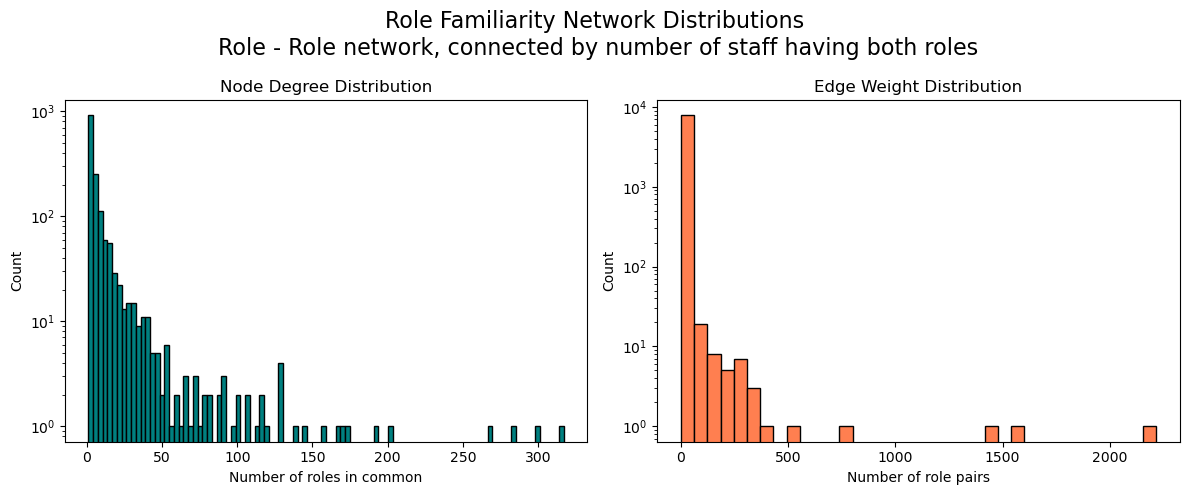

In [5]:
##########################  Building the role - role network linked by number of staff having both roles ##########################

import networkx as nx
from collections import Counter

# Build role-role network: nodes are roles, edges connect roles if staff have both roles
role_role_graph = nx.Graph()

# Collect all roles from staff_dict_100
all_roles = set()
for info in staff_dict_100.values():
    all_roles.update(entry['role'] for entry in info['anime'])

# For each staff, get their unique roles
staff_roles = {
    staff: set(entry['role'] for entry in info['anime'])
    for staff, info in staff_dict_100.items()
}

# Count staff who have both roles for each role pair
role_pair_counter = Counter()
roles_list = list(all_roles)
for staff, roles in staff_roles.items():
    roles = list(roles)
    for i in range(len(roles)):
        for j in range(i + 1, len(roles)):
            pair = tuple(sorted([roles[i], roles[j]]))
            role_pair_counter[pair] += 1

# Add edges to the graph with weight = number of staff having both roles
for (role1, role2), weight in role_pair_counter.items():
    role_role_graph.add_edge(role1, role2, weight=weight)

print(f"Role-role network: {role_role_graph.number_of_nodes()} nodes, {role_role_graph.number_of_edges()} edges")


degree_values = dict(role_role_graph.degree()).values()
edge_weights = nx.get_edge_attributes(role_role_graph, 'weight').values()


# Node degree distribution
plt.style.use('default')
plt.figure(figsize=(12, 5))
plt.suptitle('Role Familiarity Network Distributions\n Role - Role network, connected by number of staff having both roles', fontsize=16)

plt.subplot(1, 2, 1)
plt.hist(degree_values, bins=100, color='teal', edgecolor='black', log=True)
plt.title('Node Degree Distribution')
plt.xlabel('Number of roles in common')
plt.ylabel('Count')

# Edge weight distribution (number of shared anime per staff pair)
plt.subplot(1, 2, 2)
plt.hist(edge_weights, bins=36, color='coral', edgecolor='black', log=True)
plt.title('Edge Weight Distribution')
plt.xlabel('Number of role pairs')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

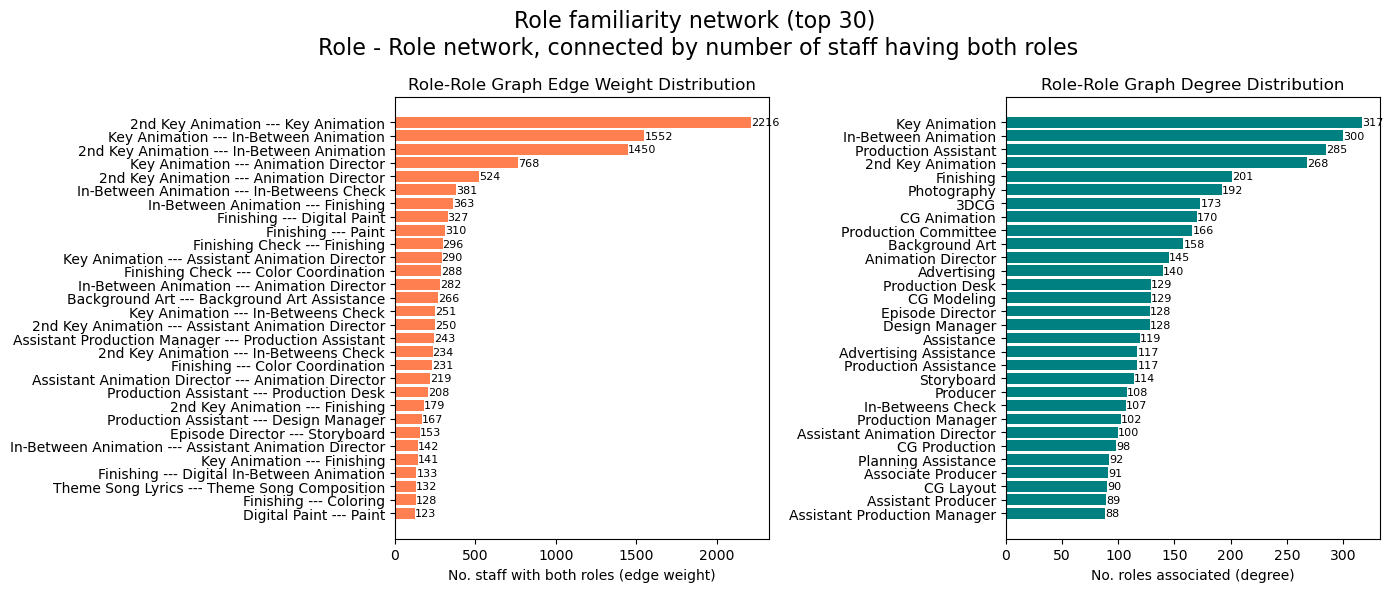

In [6]:
degrees = dict(role_role_graph.degree())
top_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:30]
role_degrees = [deg for _, deg in top_degree_nodes]


# Get top 30 roles by degree and top 30 edges by weight
degree_labels = [role for role, _ in top_degree_nodes]
degree_values = [deg for _, deg in top_degree_nodes]

top_edges = sorted(role_role_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:30]
edge_labels = [f"{u} --- {v}" for u, v, _ in top_edges]
edge_weights = [data['weight'] for _, _, data in top_edges]

plt.style.use('default')
plt.figure(figsize=(14, 6))
plt.suptitle('Role familiarity network (top 30)\n Role - Role network, connected by number of staff having both roles', fontsize=16)

plt.subplot(1, 2, 2)
bars1 = plt.barh(range(len(degree_values)), degree_values, color='teal')
plt.yticks(range(len(degree_labels)), degree_labels)
plt.xlabel('No. roles associated (degree)')
plt.title('Role-Role Graph Degree Distribution')
plt.gca().invert_yaxis()
for i, bar in enumerate(bars1):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{degree_values[i]}', va='center', ha='left', fontsize=8)

plt.subplot(1, 2, 1)
bars2 = plt.barh(range(len(edge_weights)), edge_weights, color='coral')
plt.yticks(range(len(edge_labels)), edge_labels)
plt.xlabel('No. staff with both roles (edge weight)')
plt.title('Role-Role Graph Edge Weight Distribution')
plt.gca().invert_yaxis()
for i, bar in enumerate(bars2):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{edge_weights[i]}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

Total unique role pairs with edges: 7869


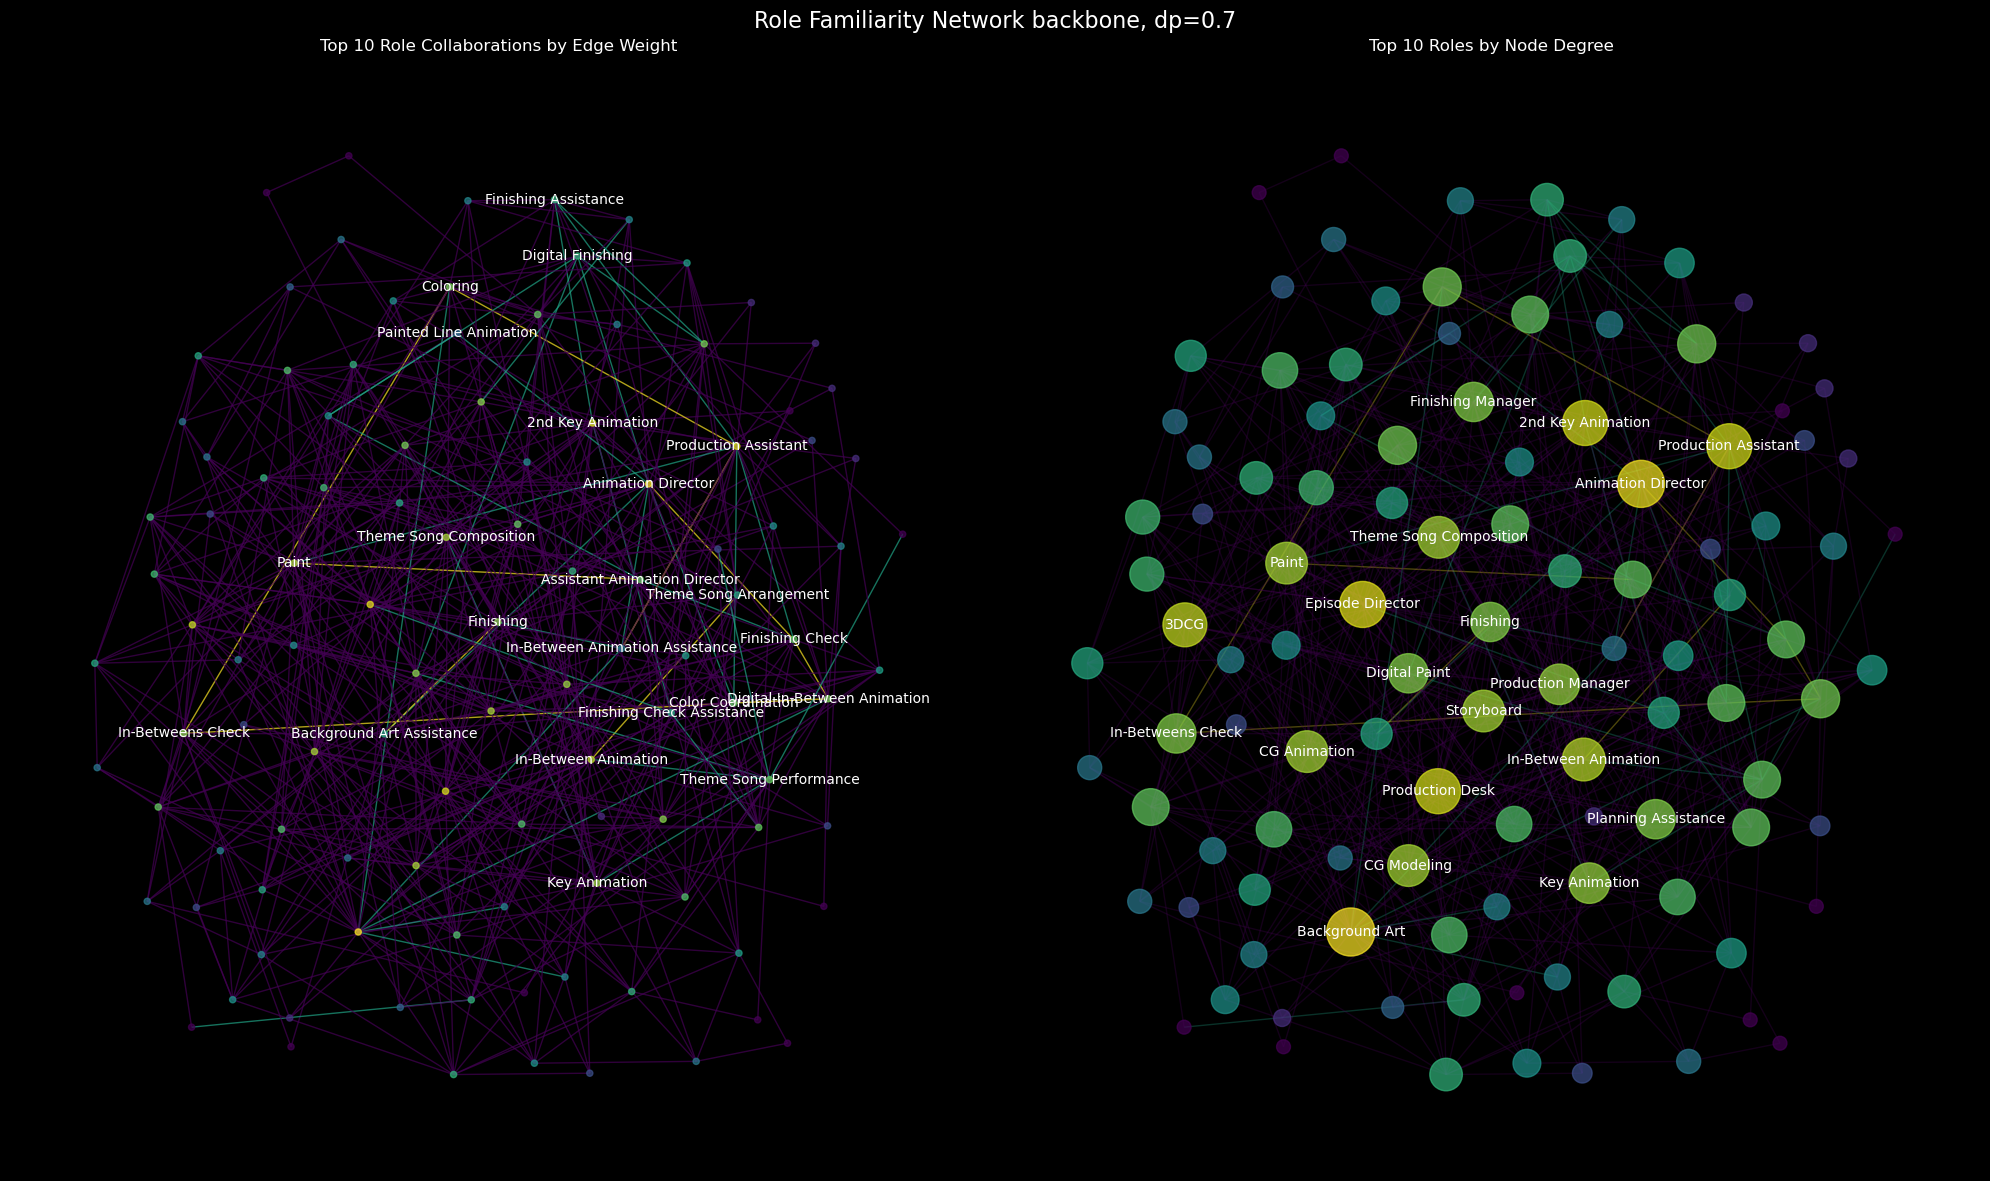

In [7]:
# Count number of edges between each pair of roles in the role-role network
role_edge_counter = Counter()

for u, v, data in role_role_graph.edges(data=True):
    weight = data.get('weight', 1)
    role_edge_counter[(u, v)] = weight

print(f"Total unique role pairs with edges: {len(role_edge_counter)}")

import disparity as dp # https://github.com/DerwenAI/disparity_filter/blob/main/disparity.py

role_graph = nx.Graph()
top_role_pairs = [((r1, r2), count) for ((r1, r2), count) in role_edge_counter.most_common(10000)]

for (r1, r2), count in top_role_pairs:
    role_graph.add_edge(r1, r2, weight=count)

dp.disparity_filter(role_graph)
dp.cut_graph(role_graph, min_alpha_ptile=0.7)

from matplotlib import cm
from matplotlib import colors

plt.style.use('dark_background')
plt.figure(figsize=(20, 12))
pos = nx.forceatlas2_layout(role_graph, strong_gravity=True, seed=2)

# Draw edges with color mapped to edge weights (log scale)
edges = role_graph.edges()
weights = [role_graph[u][v]['weight'] for u, v in edges]
log_weights = np.log10(np.array(weights) + 1)
norm_log = colors.Normalize(vmin=min(log_weights), vmax=max(log_weights))
edge_colors = [cm.viridis(norm_log(w)) for w in log_weights]

# Draw nodes with color mapped to node degree (log scale)
degrees = dict(role_graph.degree())
node_colors = np.log10(np.array([degrees[node] for node in role_graph.nodes()]) + 1)

plt.subplot(1, 2, 1)
plt.suptitle('Role Familiarity Network backbone, dp=0.7', fontsize=16)
nx.draw_networkx_edges(
    role_graph, pos, edgelist=edges, edge_color=edge_colors, alpha=0.7, width=1
)

nodes = nx.draw_networkx_nodes(
    role_graph, pos,
    node_size=20,
    node_color=node_colors,
    cmap=cm.viridis,
    alpha=0.7
)

# Draw labels for both nodes of the top 10 edges by weight
top_edges = sorted(role_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:20]
label_nodes = set()
for r1, r2, _ in top_edges:
    label_nodes.add(r1)
    label_nodes.add(r2)
labels = {node: node for node in label_nodes}
nx.draw_networkx_labels(role_graph, pos, labels=labels, font_size=10, font_color='white', alpha=1)

plt.title('Top 10 Role Collaborations by Edge Weight')
plt.axis('off')

plt.subplot(1, 2, 2)
nx.draw_networkx_edges(
    role_graph, pos, edgelist=edges, edge_color=edge_colors, alpha=0.3, width=1
)

nodes = nx.draw_networkx_nodes(
    role_graph, pos,
    node_size=50*np.array([degrees[node] for node in role_graph.nodes()]),
    node_color=node_colors,
    cmap=cm.viridis,
    alpha=0.7
)

# Draw labels for the top 10 nodes by degree
top_degree_nodes = sorted(role_graph.degree, key=lambda x: x[1], reverse=True)[:20]
label_nodes = set(node for node, _ in top_degree_nodes)
labels = {node: node for node in label_nodes}
nx.draw_networkx_labels(role_graph, pos, labels=labels, font_size=10, font_color='white', alpha=1)

#plt.colorbar(nodes, label='Node Degree (log scale)')
plt.title('Top 10 Roles by Node Degree')
plt.axis('off')

plt.tight_layout()
plt.show()

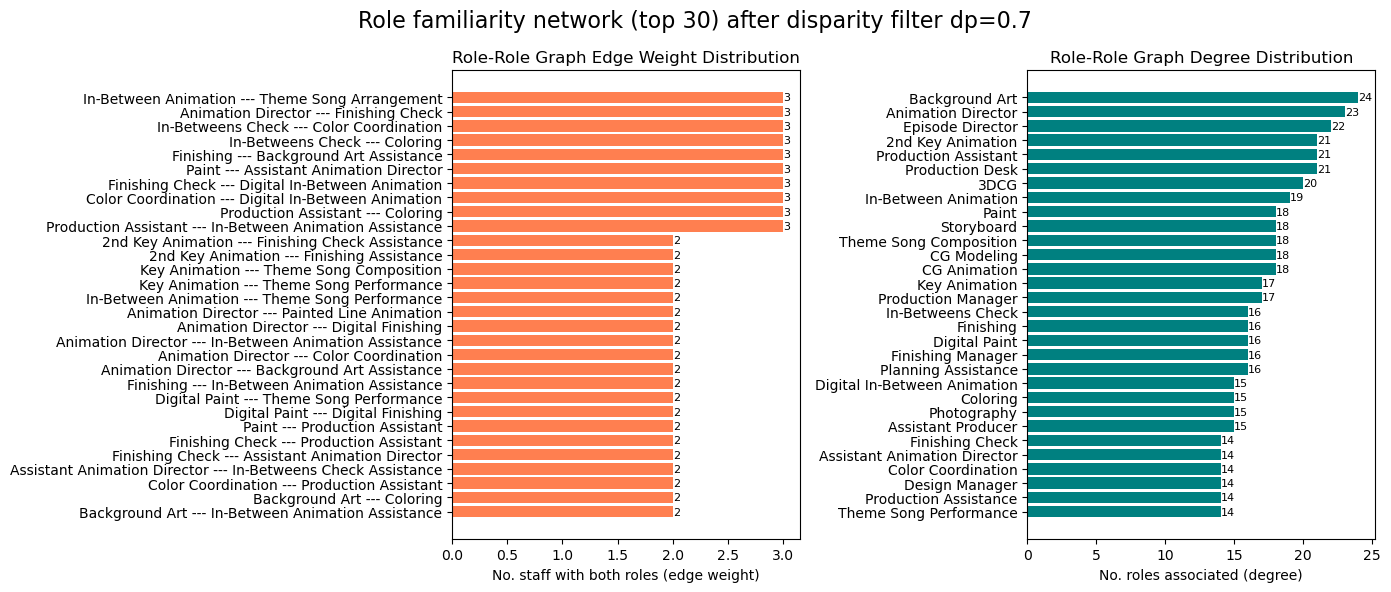

In [8]:
degrees = dict(role_graph.degree())
top_degree_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:30]
role_degrees = [deg for _, deg in top_degree_nodes]


# Get top 30 roles by degree and top 30 edges by weight
degree_labels = [role for role, _ in top_degree_nodes]
degree_values = [deg for _, deg in top_degree_nodes]

top_edges = sorted(role_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:30]
edge_labels = [f"{u} --- {v}" for u, v, _ in top_edges]
edge_weights = [data['weight'] for _, _, data in top_edges]

plt.style.use('default')
plt.figure(figsize=(14, 6))
plt.suptitle('Role familiarity network (top 30) after disparity filter dp=0.7', fontsize=16)

plt.subplot(1, 2, 2)
bars1 = plt.barh(range(len(degree_values)), degree_values, color='teal')
plt.yticks(range(len(degree_labels)), degree_labels)
plt.xlabel('No. roles associated (degree)')
plt.title('Role-Role Graph Degree Distribution')
plt.gca().invert_yaxis()
for i, bar in enumerate(bars1):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{degree_values[i]}', va='center', ha='left', fontsize=8)

plt.subplot(1, 2, 1)
bars2 = plt.barh(range(len(edge_weights)), edge_weights, color='coral')
plt.yticks(range(len(edge_labels)), edge_labels)
plt.xlabel('No. staff with both roles (edge weight)')
plt.title('Role-Role Graph Edge Weight Distribution')
plt.gca().invert_yaxis()
for i, bar in enumerate(bars2):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{edge_weights[i]}', va='center', ha='left', fontsize=8)

plt.tight_layout()
plt.show()

In [9]:
from datetime import datetime
sd100 = {}
for staff in staff_dict_100:
    sd100[staff] = []
    all_roles = set([entry['role'] for entry in staff_dict_100[staff]['anime']])
    role_starts = {}
    for role in all_roles:
        dates = []
        for entry in staff_dict_100[staff]['anime']:
            if entry['role'] == role:
                start = entry['anime_start']
                if start and all(start.get(k) is not None for k in ['year', 'month', 'day']):
                    try:
                        dates.append(datetime(start['year'], start['month'], start['day']))
                    except Exception:
                        continue
        if dates:
            role_starts[role] = min(dates)
    sd100[staff] = sorted(role_starts.items(), key=lambda x: x[1])

list(sd100.items())[:5]
role_orders = {}
for staff, roles in sd100.items():
    role_orders[staff] = [role for role, _ in roles]

import networkx as nx

role_ords = [x[1] for x in list(role_orders.items())]
role_order_graph = nx.DiGraph()
edge_counts = {}

for ord_list in role_ords:
    for i in range(len(ord_list) - 1):
        edge = (ord_list[i], ord_list[i + 1])
        edge_counts[edge] = edge_counts.get(edge, 0) + 1

for edge, count in edge_counts.items():
    role_order_graph.add_edge(*edge, weight=count)

print(f"Directed role order graph: {role_order_graph.number_of_nodes()} nodes, {role_order_graph.number_of_edges()} edges")


Directed role order graph: 1578 nodes, 5214 edges


C:\Users\bence\AppData\Local\Temp\ipykernel_3848\4188425512.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', pad=0.08, aspect=40)


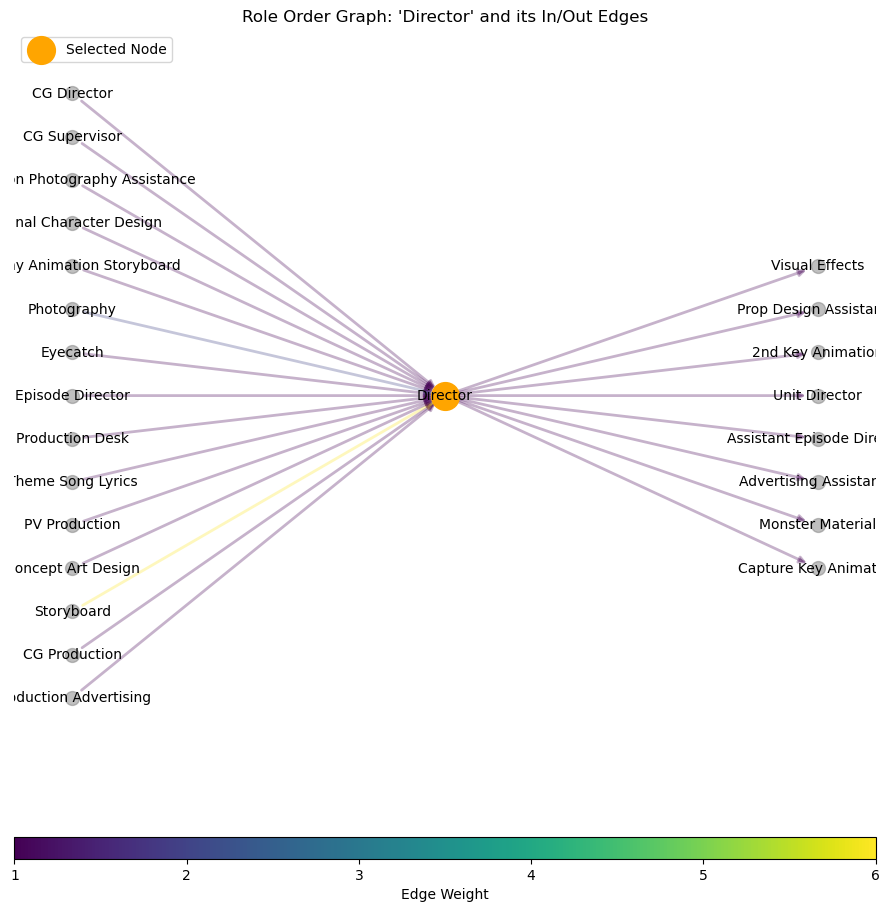

In [10]:
def plot_role_order_node(node):
    in_edges = list(role_order_graph.in_edges(node))
    out_edges = list(role_order_graph.out_edges(node))
    neighbor_nodes = set([n for n, _ in in_edges] + [n for _, n in out_edges] + [node])
    subgraph = role_order_graph.subgraph(neighbor_nodes)
    pos = {}
    center_x, center_y = 0, 0
    pos[node] = np.array([center_x, center_y])
    in_y_step = 2
    for i, (src, _) in enumerate(in_edges):
        pos[src] = np.array([center_x - 5, center_y + in_y_step * (i - len(in_edges) // 2)])
    out_y_step = 2
    for i, (_, tgt) in enumerate(out_edges):
        pos[tgt] = np.array([center_x + 5, center_y + out_y_step * (i - len(out_edges) // 2)])
    plt.figure(figsize=(10, 10))
    plt.title(f"Role Order Graph: '{node}' and its In/Out Edges")
    nx.draw_networkx_nodes(subgraph, pos, nodelist=neighbor_nodes, node_size=100, node_color='gray', alpha=0.5)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[node], node_size=400, node_color='orange', label='Selected Node')
    in_edge_weights = [subgraph.get_edge_data(src, node).get('weight', 1) for src, _ in in_edges]
    out_edge_weights = [subgraph.get_edge_data(node, tgt).get('weight', 1) for _, tgt in out_edges]
    all_weights = in_edge_weights + out_edge_weights
    norm = plt.Normalize(min(all_weights), max(all_weights))
    cmap = plt.cm.viridis
    nx.draw_networkx_edges(
        subgraph, pos, edgelist=in_edges,
        edge_color=[cmap(norm(w)) for w in in_edge_weights],
        width=2, alpha=0.3, label='In-edges'
    )
    nx.draw_networkx_edges(
        subgraph, pos, edgelist=out_edges,
        edge_color=[cmap(norm(w)) for w in out_edge_weights],
        width=2, alpha=0.3, label='Out-edges'
    )
    labels = {n: n for n in neighbor_nodes}
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='horizontal', pad=0.08, aspect=40)
    cbar.set_label('Edge Weight')
    plt.legend(loc='upper left')
    plt.axis('off')
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

# Example usage:
plot_role_order_node('Director')


C:\Users\bence\AppData\Local\Temp\ipykernel_3848\4188425512.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', pad=0.08, aspect=40)


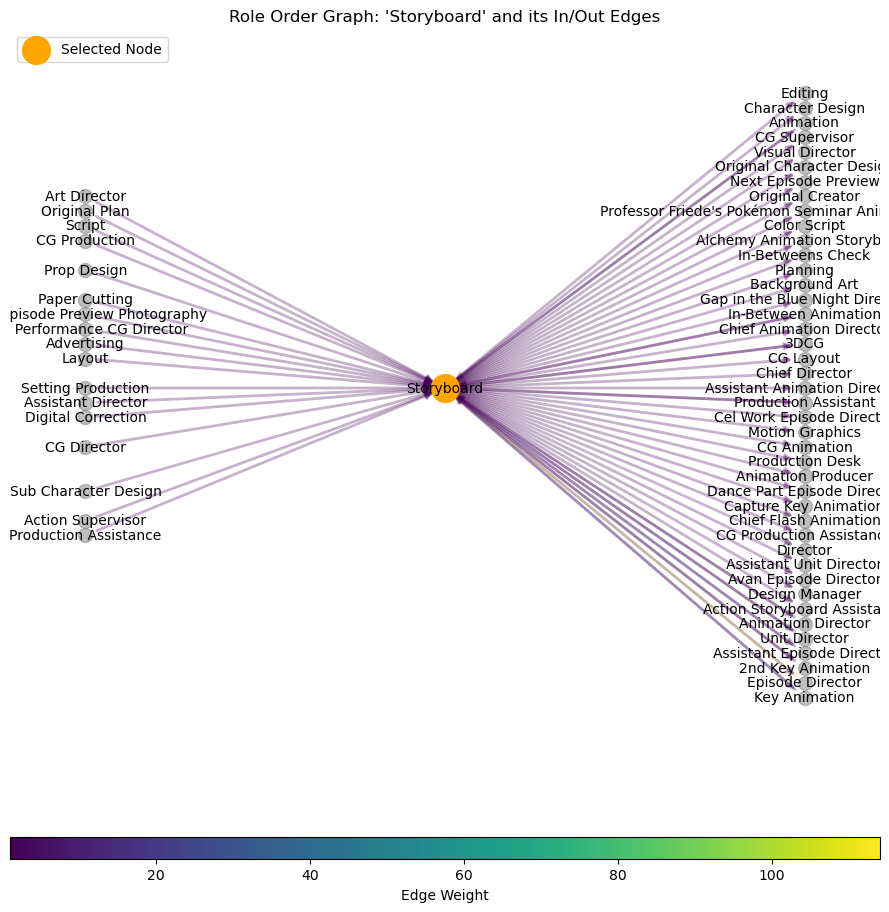

In [13]:
plot_role_order_node('Storyboard')

In [37]:
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import community as community_louvain

#Didn't use these imports, but they might be useful later
#from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
#from wordcloud import WordCloud

with open('data/anime_data_100_to_200_full.json', 'r', encoding='utf-8') as f:
    anime_data = json.load(f)

In [ ]:

G = nx.Graph()
anime_chars = defaultdict(list)  # Maps character names to list of anime IDs they appear in
chars_to_genres = defaultdict(set)  # Maps character names to set of genres they're associated with
chars_to_desc = {}  # Maps character names to their descriptions
chars_to_scores = defaultdict(list)  # Maps character names to list of anime scores they appear in


for anime in anime_data:
    anime_id = anime['id'] # Extracts anime details
    anime_title = anime['title']['romaji']
    genres = anime.get('genres', [])
    score = anime.get('averageScore', 0)
    characters = [c['name'] for c in anime.get('characters', []) if c.get('name')] # Extracts list of character names appearing in this anime
    
    # Building character attribute dictionaries
    for char in anime.get('characters', []):
        char_name = char.get('name')
        if char_name:
            anime_chars[char_name].append(anime_id)
            chars_to_genres[char_name].update(genres)
            chars_to_scores[char_name].append(score)
            if char.get('description'):
                chars_to_desc[char_name] = char['description']
    
    # Creates edges between characters who appear in the same anime and use nested loop to generate all unique character pairs
    for i, char1 in enumerate(characters):
        for char2 in characters[i+1:]:
            if G.has_edge(char1, char2): # If edge exists, increment weight; otherwise create new edge with weight 1
                G[char1][char2]['weight'] += 1
            else:
                G.add_edge(char1, char2, weight=1)

print(f"Graph has {G.number_of_nodes()} nodes(characters) and {G.number_of_edges()} edges(connections).")


Graph has 3947 nodes(characters) and 127065 edges(connections).


In [ ]:

Gcc = sorted(nx.connected_components(G), key=len, reverse=True) # Connected components are subgraphs where every node is reachable from every other node
largest_cc = G.subgraph(Gcc[0]).copy() # Extract the largest connected component for analysis #.copy() to avoid modifying original graph

print(f'{"-"*20} Basic Network Stats {"-"*20}')
stats = {
    'Total no.of characters': G.number_of_nodes(), # Basic graph size metrics
    'Total no.of connections': G.number_of_edges(),
    'Largest connected component size': largest_cc.number_of_nodes(), # Connected component analysis
    'Largest connected component percentage': f"{(largest_cc.number_of_nodes()/G.number_of_nodes())*100:.2f}%",
    'Average degree': f"{np.mean([d for n, d in G.degree()]):.2f}",  # Degree centrality: average number of connections per character
    'Network density': f"{nx.density(G):.4f}", # Network density: ratio of actual edges to possible edges (ranges from 0 to 1)
    'Average clustering': nx.average_clustering(largest_cc),# Clustering coefficient: measures how much nodes tend to cluster together (0 to 1) # Higher values indicate characters form tightly-knit groups
    'Network diameter': nx.diameter(largest_cc) if nx.is_connected(largest_cc) else 'N/A (not connected)', # Network diameter: longest shortest path between any two nodes
}

for key, val in stats.items():
    if isinstance(val, (int, float)):
        print(f"{key:<40}: {val:.4f}" if isinstance(val, float) else f"{key:<40}: {val}")
    else:
        print(f"{key:<40}: {val}")


-------------------- Basic Network Stats --------------------
Total no.of characters                  : 3947
Total no.of connections                 : 127065
Largest connected component size        : 2953
Largest connected component percentage  : 74.82%
Average degree                          : 64.39
Network density                         : 0.0163
Average clustering                      : 0.9828
Network diameter                        : 9


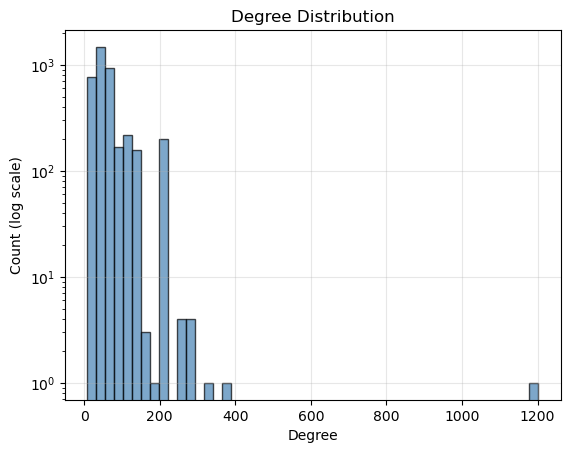

In [20]:
ax1 = plt.subplot(1, 1, 1)
degrees = [d for n, d in G.degree()]
ax1.hist(degrees, bins=50, color='steelblue', edgecolor='black', alpha =0.7)
ax1.set_xlabel('Degree', fontsize=10)
ax1.set_ylabel('Count (log scale)', fontsize=10)
ax1.set_title('Degree Distribution', fontsize=12)
ax1.set_yscale('log')
ax1.set_xscale
ax1.grid(alpha=0.3)

In [ ]:
# Create separate network graphs for each genre
# defaultdict with lambda creates a new NetworkX Graph automatically when accessing a new genre key
genre_network = defaultdict(lambda: nx.Graph())
for anime in anime_data:
    genres = anime.get('genres', [])
    if not genres:
        continue

    primary_genre = genres[0]
    characters = [c['name'] for c in anime.get('characters', []) if c.get('name')]
    
    # Create edges between all character pairs within this anime as this represents co-appearances in the same anime
    for i, char1 in enumerate(characters):
        for char2 in characters[i+1:]:
            for genre in genres:
                if genre_network[primary_genre].has_edge(char1, char2): 
                    genre_network[primary_genre][char1][char2]['weight'] += 1  # Weight represents number of co-appearances
                else:
                    genre_network[primary_genre].add_edge(char1, char2, weight=1)


genre_stats = []
for genre, g_net in genre_network.items():
    if g_net.number_of_nodes() < 10:    # Filter out genres with very small networks (< 10 characters) # Small networks can produce unreliable statistical metrics
        continue
    
    try:
        gcc = sorted(nx.connected_components(g_net), key=len, reverse=True)
        largest_cc = g_net.subgraph(gcc[0]).copy()
        
        # Compiles comprehensive network metrics for a particular genre
        genre_stats.append({
            'Genre': genre,
            'Characters': g_net.number_of_nodes(),  # Total unique characters
            'Connections': g_net.number_of_edges(),  # Total co-appearance relationships
            'Largest CC Size': largest_cc.number_of_nodes(),  # Size of main network cluster
            'Avg Degree': f"{np.mean([d for n, d in g_net.degree()]):.2f}",  # Average connections per character
            'Density': f"{nx.density(g_net):.4f}",  # How interconnected the network is (0-1)
            'Avg Clustering': f"{nx.average_clustering(largest_cc):.4f}",  # Tendency to form tight groups (0-1)
            'Diameter': nx.diameter(largest_cc) if nx.is_connected(largest_cc) else 'N/A (not connected)',  # Maximum shortest path
        })
    except:
        continue

# Convert to pandas DataFrame and sort by network density
# Density indicates how tightly connected characters are within each genre
genre_df = pd.DataFrame(genre_stats).sort_values(by='Density', ascending=False)
print(f"{'-'*20}Genre-wise Network Stats{'-'*20}")
print(genre_df.to_string(index=False))



--------------------Genre-wise Network Stats--------------------
    Genre  Characters  Connections  Largest CC Size Avg Degree Density Avg Clustering  Diameter
  Mystery          58         1653               58      57.00  1.0000         1.0000         1
Adventure         115         2246               58      39.06  0.3426         1.0000         1
    Drama         399         9283               70      46.53  0.1169         1.0000         1
   Comedy         735        16438              218      44.73  0.0609         0.9941         3
   Action        2675        97452             2100      72.86  0.0272         0.9828         8


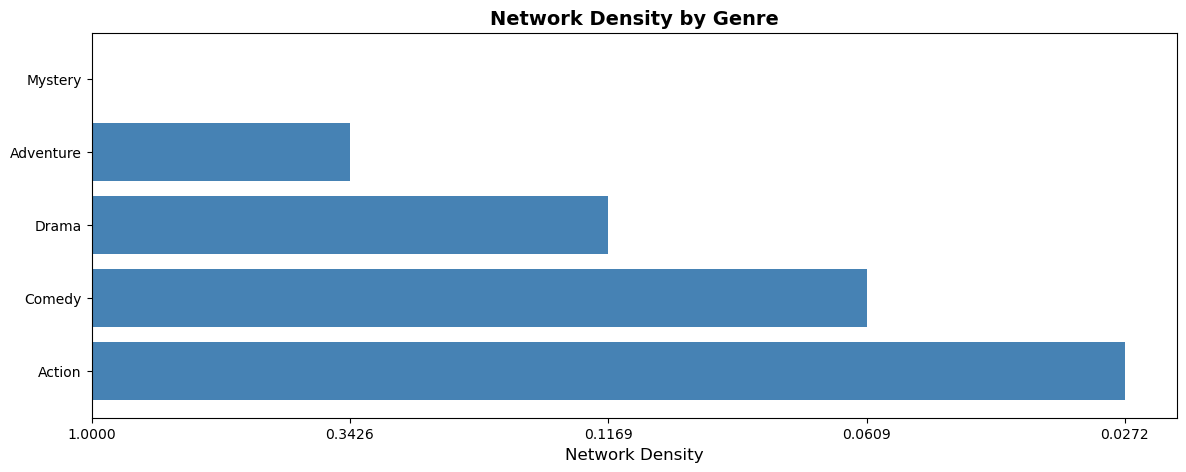

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 5))
axes.barh(genre_df['Genre'], genre_df['Density'], color='steelblue')
axes.set_xlabel('Network Density', fontsize=12)
axes.set_title('Network Density by Genre', fontsize=14, fontweight='bold')
axes.invert_yaxis()
plt.show()


In [ ]:

# Applying Louvain community detection algorithm to the largest connected component
print(f"{'-'*20}Community Detection{'-'*20}")
communities = community_louvain.best_partition(largest_cc)
num_communities = len(set(communities.values())) # Counts the number of distinct communities identified
print(f"Number of communities detected using Louvain algorithm: {num_communities}")

community_sizes = Counter(communities.values()) # Analyzing community size distribution
print("Top 5 largest communities:")
for comm_id, size in community_sizes.most_common(5):
    print(f"Community {comm_id}: {size} characters")

modularity = community_louvain.modularity(communities, largest_cc) # Calculate modularity score to evaluate partition quality
print(f"Modularity of the partition: {modularity:.4f}")  # Higher score, Value > 0.3 gives better defined communities i.e., seperation
print(f"{'-'*20}Community Genre Alignment{'-'*20}")

community_genres = defaultdict(lambda: defaultdict(int)) # Map each community to its genre distribution
for node in largest_cc.nodes():
    comm_id = communities[node]
    genres = chars_to_genres.get(node, set()) 
    for genre in genres:
        community_genres[comm_id][genre] += 1

# Display top 5 genres for each of the 5 largest communities
# This helps identify if communities are genre-specific (e.g., all Action or all Romance)
for comm_id, size in community_sizes.most_common(5):
    top_genres = sorted(community_genres[comm_id].items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nCommunity {comm_id} (size: {size}):")
    for genre, count in top_genres:
        percentage = (count / size) * 100
        print(f"  {genre}: {count} characters ({percentage:.1f}%)")


--------------------Community Detection--------------------
Number of communities detected using Louvain algorithm: 7
Top 5 largest communities:
Community 5: 42 characters
Community 3: 39 characters
Community 4: 38 characters
Community 6: 37 characters
Community 0: 26 characters
Modularity of the partition: 0.7556
--------------------Community Genre Alignment--------------------

Community 5 (size: 42):
  Comedy: 42 characters (100.0%)
  Sports: 42 characters (100.0%)

Community 3 (size: 39):
  Slice of Life: 39 characters (100.0%)
  Supernatural: 39 characters (100.0%)
  Drama: 39 characters (100.0%)
  Comedy: 39 characters (100.0%)
  Romance: 39 characters (100.0%)

Community 4 (size: 38):
  Romance: 38 characters (100.0%)
  Comedy: 38 characters (100.0%)
  Slice of Life: 38 characters (100.0%)
  Drama: 1 characters (2.6%)

Community 6 (size: 37):
  Romance: 37 characters (100.0%)
  Comedy: 37 characters (100.0%)
  Slice of Life: 37 characters (100.0%)
  Psychological: 37 characters 

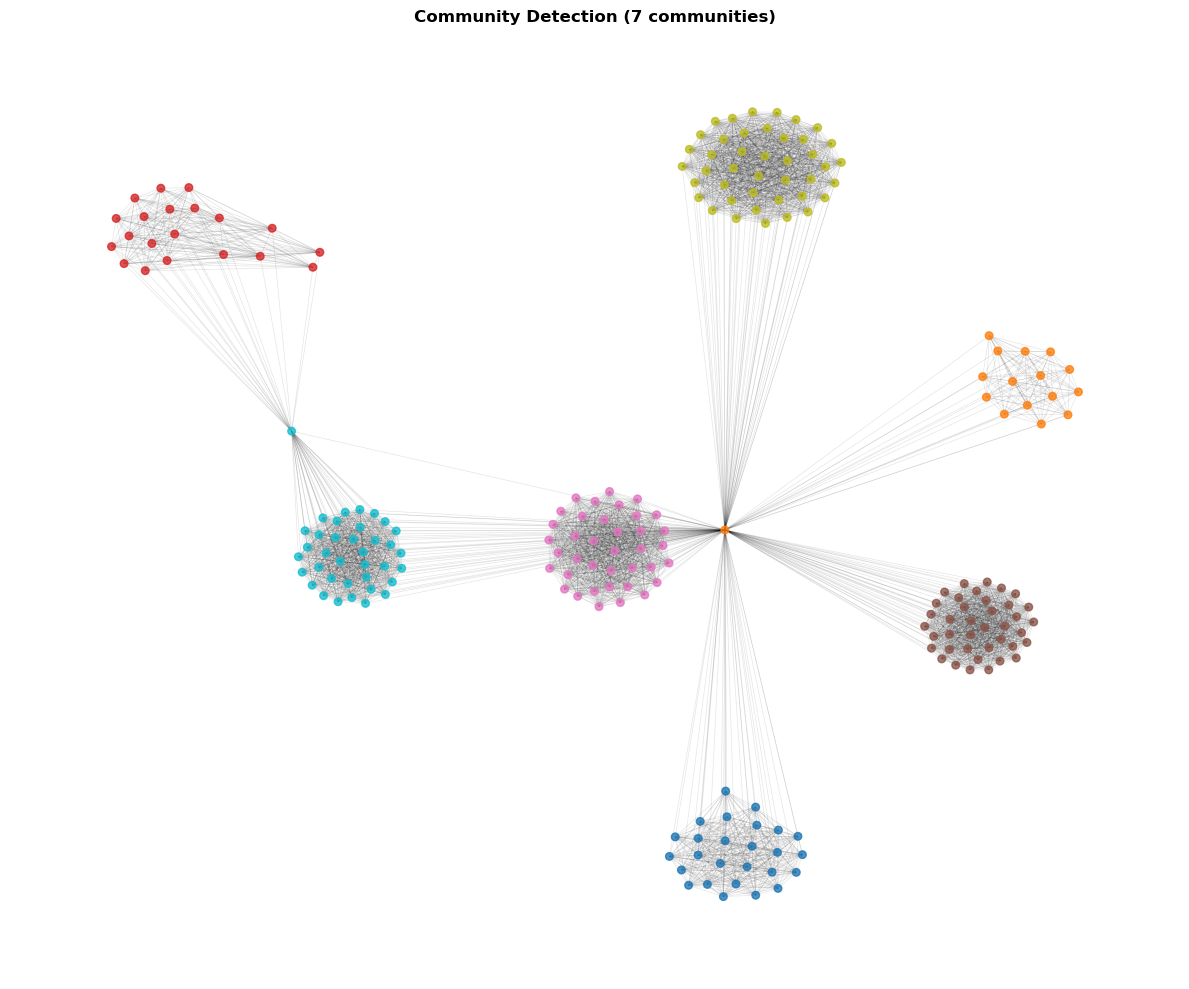

In [ ]:

plt.figure(figsize=(12, 10))
ax4 = plt.subplot(1, 1, 1)
if largest_cc.number_of_nodes() > 500:
    nodes_sample = list(largest_cc.nodes())[:500]
    G_sample = largest_cc.subgraph(nodes_sample).copy()
    comm_sample = {node: communities[node] for node in nodes_sample}
else:
    G_sample = largest_cc
    comm_sample = communities
    
pos = nx.spring_layout(G_sample, k=0.3, iterations=30, seed=42)
node_colors = [comm_sample[node] for node in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, 
                       node_size=30, alpha=0.8, ax=ax4, cmap='tab10')
nx.draw_networkx_edges(G_sample, pos, alpha=0.1, width=0.5, ax=ax4)

ax4.set_title(f'Community Detection ({num_communities} communities)', 
              fontsize=12, fontweight='bold')
ax4.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

# Perform sentiment analysis on character descriptions using TextBlob # TextBlob polarity ranges from -1.0 (most negative) to +1.0 (most positive), with 0 as neutral
print(f"{'-'*20}Sentiment Analysis{'-'*20}")
char_sentiments = {}
for char_name, desc in chars_to_desc.items():
    # Filters out very short descriptions (< 30 characters) which are too brief for reliable sentiment analysis
    if len(desc) > 30:
        try:
            sentiment = TextBlob(desc).sentiment.polarity
            char_sentiments[char_name] = sentiment
        except:
            continue

print(f"Analyzed sentiment for {len(char_sentiments)} characters.")

# We analyze sentiment correlation with network centrality (degree)
# High-degree nodes are "hub" characters who appear frequently with others
# Low-degree nodes are "peripheral" characters with fewer connections
degrees_dict = dict(largest_cc.degree())
high_centrality = [n for n in largest_cc.nodes() if degrees_dict[n] >= np.percentile(list(degrees_dict.values()), 75)]
low_centrality = [n for n in largest_cc.nodes() if degrees_dict[n] <= np.percentile(list(degrees_dict.values()), 25)]
high_centrality_sentiments = [char_sentiments[n] for n in high_centrality if n in char_sentiments]
low_centrality_sentiments = [char_sentiments[n] for n in low_centrality if n in char_sentiments]

print(f'\n{"-"*20}Sentiment based on character centrality{"-"*20}')
print(f"High Centrality characters (top 25%):")
print(f'Count: {len(high_centrality_sentiments)}')
print(f'Average Sentiment: {np.mean(high_centrality_sentiments):.4f}')
print(f'Standard Deviation: {np.std(high_centrality_sentiments):.4f}')
print(f'\nLow Centrality characters (bottom 25%):')
print(f'Count: {len(low_centrality_sentiments)}')   
print(f'Average Sentiment: {np.mean(low_centrality_sentiments):.4f}')
print(f'Standard Deviation: {np.std(low_centrality_sentiments):.4f}')

print('\n')
print(f"{'-'*20}Sentiment by Genre{'-'*20}")

genre_sentiments = defaultdict(list)
for anime in anime_data:
    genres = anime.get('genres', [])
    if not genres:
        continue
    primary_genre = genres[0]
    
    # Collect the sentiment scores for all characters in this anime
    for char in anime.get('characters', []):
        char_name = char.get('name')
        if char_name in char_sentiments:
            genre_sentiments[primary_genre].append(char_sentiments[char_name])

# Display sentiment statistics for top 5 genres (by network density; 5 for reliability)
for genre in genre_df.head(5)['Genre'].values:
    if genre in genre_sentiments and len(genre_sentiments[genre]) > 5:
        avg_sentiment = np.mean(genre_sentiments[genre])
        # Shows whether certain genres (e.g., Comedy vs. Drama) have different character portrayals
        print(f"Genre: {genre}, Count: {len(genre_sentiments[genre])}, Average Sentiment: {avg_sentiment:.4f}")

--------------------Sentiment Analysis--------------------
Analyzed sentiment for 3045 characters.

--------------------Sentiment based on character centrality--------------------
High Centrality characters (top 25%):
Count: 74
Average Sentiment: 0.0913
Standard Deviation: 0.1235

Low Centrality characters (bottom 25%):
Count: 45
Average Sentiment: 0.1033
Standard Deviation: 0.2017


--------------------Sentiment by Genre--------------------
Genre: Mystery, Count: 22, Average Sentiment: 0.0669
Genre: Adventure, Count: 79, Average Sentiment: 0.0890
Genre: Drama, Count: 243, Average Sentiment: 0.0846
Genre: Comedy, Count: 700, Average Sentiment: 0.0908
Genre: Action, Count: 2254, Average Sentiment: 0.0758


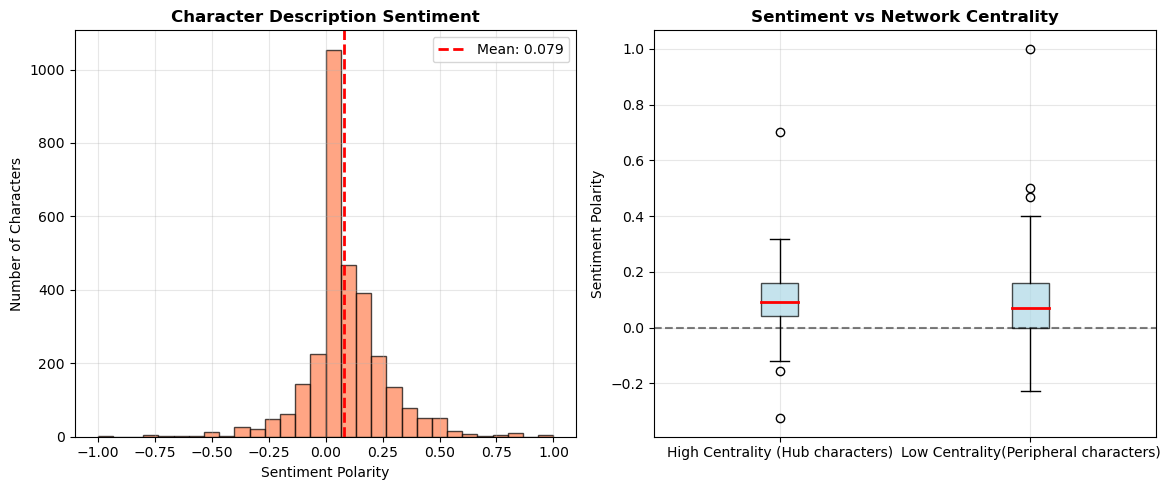

In [ ]:

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(12, 5))
all_sentiments = list(char_sentiments.values())
ax5.hist(all_sentiments, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax5.set_xlabel('Sentiment Polarity', fontsize=10)
ax5.set_ylabel('Number of Characters', fontsize=10)
ax5.axvline(np.mean(all_sentiments), color='red', linestyle='dashed', 
            linewidth=2, label=f'Mean: {np.mean(all_sentiments):.3f}')
ax5.set_title('Character Description Sentiment', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

centrality_data = [high_centrality_sentiments, low_centrality_sentiments]
labels = ['High Centrality (Hub characters)', 'Low Centrality(Peripheral characters)']
bp = ax6.boxplot(centrality_data, labels=labels, patch_artist=True, 
                 boxprops=dict(facecolor='lightblue', alpha=0.7), 
                 medianprops=dict(color='red', linewidth=2))
ax6.set_ylabel('Sentiment Polarity', fontsize=10)
ax6.set_title('Sentiment vs Network Centrality', fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3)
ax6.axhline(0, color='black', linestyle='dashed', alpha=0.5)
plt.tight_layout()
plt.show()
